## 1.  Strategy Design
<hr>

The idea of this code is:
1. Generate a Investment Strategy which rebalances a portfolio.
2. Observe a general metrics about performance.
3. Convert this portfolio into a ETF.
4. Monitor the ETF value and implement control features.


In this code snippet, we are importing several libraries that will be used in our ETF project:

- ***yfinance*** is a popular library for retrieving financial data from Yahoo Finance.
- ***matplotlib*** and ***seaborn*** are plotting libraries that will allow us to create visualizations of our data.
- ***pandas*** is a library for data manipulation and analysis.
- ***numpy*** is a library for numerical computing.

In [1]:
# Selecting libraries
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Next, we define a list of stocks that we will be tracking in our ETF project. In this case, we have chosen to track four assets: 
1. ***SPY*** (an ETF that tracks the S&P 500)
2. ***GLD*** (an ETF that tracks the price of gold)
3. ***^TNX*** (the yield of the 10-year U.S. Treasury note)
4. ***^IRX*** (the yield of the 13-week U.S. Treasury bill).

We also define some initial values for our project:

- ***initial_value*** is the amount of money we will be investing in our ETF project. In this case, we have set it to $1,000,000.
- ***initial_etf_shares*** is the number of shares of our ETF that we will initially distributed. In this case, we have set it to 100,000.
- ***allocation*** is the proportion of our initial investment that we will allocate to each asset in our portfolio. In this case, we have chosen to allocate 25% to each asset.
- ***start_date*** is the date to start the data retrieval from.
- The target for the example is to mantain a 25% distribution per asset rebalancing daily. This can be done monthly, quarterly, yearly, etc. The tool will be rebalance the shares weights.

In [2]:
# Define the assets and key initial metrics as investment amount to generate a portfolio and the number of ETF shares created
stocks = ['SPY', 'GLD', '^TNX', '^IRX']
initial_value = 10**6 
initial_etf_shares = 10**5
allocation = 0.25
start_date = '2005-01-01'

On this simple step, we will retreive the data from ***yfinance*** library. We will clean the data since few missing values exsists and we will store the prices ***values*** for later usage.
We will also calculate the log_returns for the assets and clean the first NaN value.

In [3]:
# Download data, clean and isolate values for calculation
stock_data = yf.download(stocks, start=start_date)['Adj Close']
stock_data = stock_data.dropna()
stock_prices = stock_data[stocks].values

[*********************100%***********************]  4 of 4 completed


In [4]:
for asset in stock_data:
    stock_data[f'{asset}_ret'] =  np.log(stock_data[f'{asset}'] / stock_data[f'{asset}'].shift(1))
stock_data= stock_data.dropna()

In [5]:
stock_data.head()

,GLD,SPY,^IRX,^TNX,GLD_ret,SPY_ret,^IRX_ret,^TNX_ret
Date,,,,,,,,
2005-01-04,42.740002,83.856934,2.292,4.283,-0.006530,-0.012295,0.039151,0.014819
2005-01-05,42.669998,83.278305,2.282,4.277,-0.001639,-0.006924,-0.004373,-0.001402
2005-01-06,42.150002,83.701714,2.267,4.272,-0.012261,0.005071,-0.006595,-0.001170
2005-01-07,41.840000,83.581741,2.277,4.285,-0.007382,-0.001434,0.004401,0.003038
2005-01-10,41.950001,83.976959,2.273,4.278,0.002626,0.004717,-0.001758,-0.001635


The following code calculates the ***daily rebalance*** of a portfolio our four assets.

First, a DataFrame is created to store the number of shares of each asset in the portfolio. The initial number of shares for each asset is calculated based on the initial allocation, which is 25% for each asset, and the initial value of the portfolio, which is 1 million USD.

Then:
- The code iterates over each day in the DataFrame containing the daily prices of the assets and updates the number of shares to maintain the allocation. 
- For each day, the current value of the portfolio is calculated by multiplying the number of shares of each asset by its corresponding price. 
- The target value for each asset is the product of the current value of the portfolio and the allocation for that asset.
- The target number of shares is calculated by dividing the target value by the price of the asset for that day. 
- The number of shares for each asset is then updated in the shares DataFrame.

Finally, the code rounds down the number of shares to the nearest integer, as it is not possible to buy fractional shares. The resulting DataFrame contains the daily number of shares for each asset. ***If you are looking for other asset such cryptocurrencies, fractional shares, etc, you shouldn't floor the result.***

In [6]:
### Daily rebalance process ### if you want to do monthly, quarterly or yearly this is your area to to work.
 
# Calculate the initial number of shares for each asset based on the initial allocation
shares_df = pd.DataFrame(index=[stock_data.index[0]])
for asset in stocks:
    initial_shares = (initial_value * allocation) / stock_data[asset][stock_data.index[0]]
    shares_df[asset + '_shares'] = initial_shares

# Iterate over each day in the year and update the number of shares to maintain the allocation
for day in stock_data.index:
    if day == stock_data.index[0]:
        continue
    # Calculate the current value of the portfolio
    current_value = 0
    for asset in stocks:
        current_value += shares_df[asset + '_shares'][stock_data.index[0]] * stock_data[asset][day]
    # Update the number of shares for each asset
    for asset in stocks:
        target_value = current_value * allocation
        target_shares = target_value / stock_data[asset][day]
        shares_df.loc[day, asset + '_shares'] = target_shares

# Rounded since no fractional shares/positions
for i in shares_df.columns:
    shares_df[i] = np.floor(shares_df[i])  

shares_df.head()

,SPY_shares,GLD_shares,^TNX_shares,^IRX_shares
2005-01-04,2981.0,5849.0,58370.0,109075.0
2005-01-05,2991.0,5837.0,58243.0,109161.0
2005-01-06,2965.0,5888.0,58094.0,109474.0
2005-01-07,2968.0,5929.0,57899.0,108958.0
2005-01-10,2957.0,5919.0,58051.0,109257.0


Then calculates the value for each asset in the portfolio $value = price * shares $, and determines how many shares of each asset need to be bought or sold to bring the portfolio back to the desired allocation on the ***trade_{asset}_shares***. This will order to place. 

- First calculates the value and shares for each asset by multiplying the asset's price by the number of shares held, and stores this information in new columns in the stock_data DataFrame.
- Second calculates the amount of shares that need to be traded to maintain the desired allocation by taking the difference between the current number of shares and the previous number of shares, and stores this information in new columns in the ***stock_data*** DataFrame. 
- The ***fillna(0)*** function is used to set the first column of shares to be traded to 0, since there is no previous value to compare it to and avoid ***NaN***.

Finally, the code calculates the total portfolio value by summing up the value of each asset in ***stock_data['Portfolio']***, the portfolio returns as we did with the individual stocks and visualizes the trading routines by showing the number of shares to trade for each asset in the first few rows of the stock_data DataFrame.

In [7]:
# Calculate the value and shares for each asset in the portfolio
for asset in stocks:
    stock_data[f'{asset}_value'] = stock_data[asset] * shares_df[f'{asset}_shares']
    stock_data[f'{asset}_shares'] = shares_df[f'{asset}_shares']
    stock_data[f'Trade_{asset}_shares'] = np.floor(stock_data[f'{asset}_shares']) - np.floor(stock_data[f'{asset}_shares'].shift(1))

stock_data = stock_data.fillna(0) # Set 0 first column of shares to trade

# Calculate the total portfolio value
stock_data['Portfolio'] = stock_data[[f'{asset}_value' for asset in stocks]].sum(axis=1)
stock_data['Portfolio_ret'] = np.log(stock_data['Portfolio']/stock_data['Portfolio'].shift(1).dropna())

# Visualize Trading Routines, every new input will be our trading routine to keep the portfolio allocation
stock_data[[f'Trade_{asset}_shares' for asset in stocks]].head()

,Trade_SPY_shares,Trade_GLD_shares,Trade_^TNX_shares,Trade_^IRX_shares
Date,,,,
2005-01-04,0.0,0.0,0.0,0.0
2005-01-05,10.0,-12.0,-127.0,86.0
2005-01-06,-26.0,51.0,-149.0,313.0
2005-01-07,3.0,41.0,-195.0,-516.0
2005-01-10,-11.0,-10.0,152.0,299.0


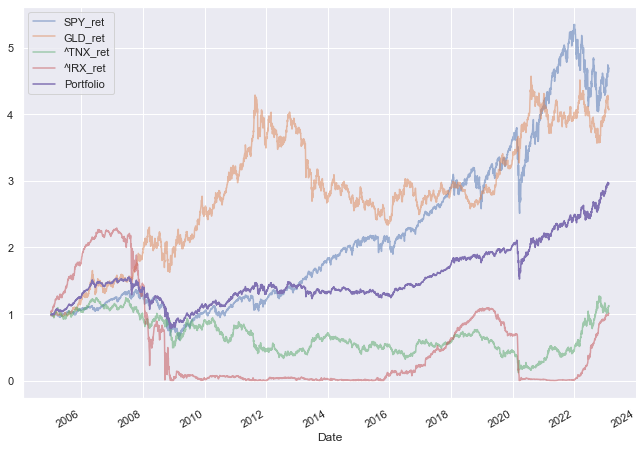

In [8]:
# Let's visualize our assets and portfolio.
stock_data[[f'{asset}_ret' for asset in stocks]].cumsum().apply(np.exp).plot(figsize=(11, 8), alpha=0.5)
stock_data['Portfolio_ret'].cumsum().apply(np.exp).plot(label='Portfolio')
plt.legend(loc="upper left")

Here we will finish the first part of our project. We've covered the following steps:
1. Define a investment strategy. 25% permanent allocation on $n$ assets. Ideally would take us through different economic environments successfully.
    1. For more examples have a look at ***Ray Dalio all wheather portfolio*** or ***Harry Browne permanent porfolio***, and play with some assets, distributions and rebalances.
2. Retreive, clean and process the data. Include relevant metrics such returns, which will help us later on
3. Define the ***rebalance routine*** and get the ***trading routines*** to mantain our allocation.
4. Visualize the performance. 



### 2. Analysis of investment strategy
<hr>

Since is not the main purpose of this code, we won't go in depth about the analytics of the investment strategy, deeper statistics, metrics or risk analysis itself. I will share few lines about how you can quickly visualize a general report. However always pay attention to:
- Correlation between your strategy and assets.
- Correlation between strategies on your system.
- Risk Management

And more important, does the strategy, exposure and rebalance practices meet your initial criteria?

As said before, here you have a quick way to observe the performance. There are many ways to do it an you can go in depth as much as you like. Here we will use a simple function from ***pyfolio*** library for a quick report, since we've got our DataFrame prepared with the returns already calculated.

Start date,2005-01-04
End date,2023-02-14
Total months,216
,Backtest
Annual return,5.127%
Cumulative returns,146.756%
Annual volatility,14.272%
Sharpe ratio,0.42
Calmar ratio,0.10
Stability,0.49
Max drawdown,-52.874%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,52.87,2007-07-19,2008-12-04,2018-01-08,2733
1,28.49,2020-02-19,2020-03-20,2020-12-17,217
2,8.50,2022-04-19,2022-05-12,2022-08-10,82
3,7.55,2006-05-10,2006-06-13,2007-01-31,191
4,6.73,2018-11-07,2018-12-24,2019-02-05,65


Stress Events,mean,min,max
Lehman,-0.30%,-8.23%,13.70%
US downgrade/European Debt Crisis,0.34%,-1.97%,2.23%
Fukushima,0.20%,-1.03%,1.44%
EZB IR Event,0.04%,-0.81%,1.70%
Aug07,-0.28%,-5.64%,3.73%
Mar08,-0.37%,-5.32%,6.73%
Sept08,-0.41%,-8.23%,13.70%
2009Q1,0.17%,-3.51%,2.85%
2009Q2,0.14%,-2.97%,2.06%
Flash Crash,0.15%,-0.44%,1.41%


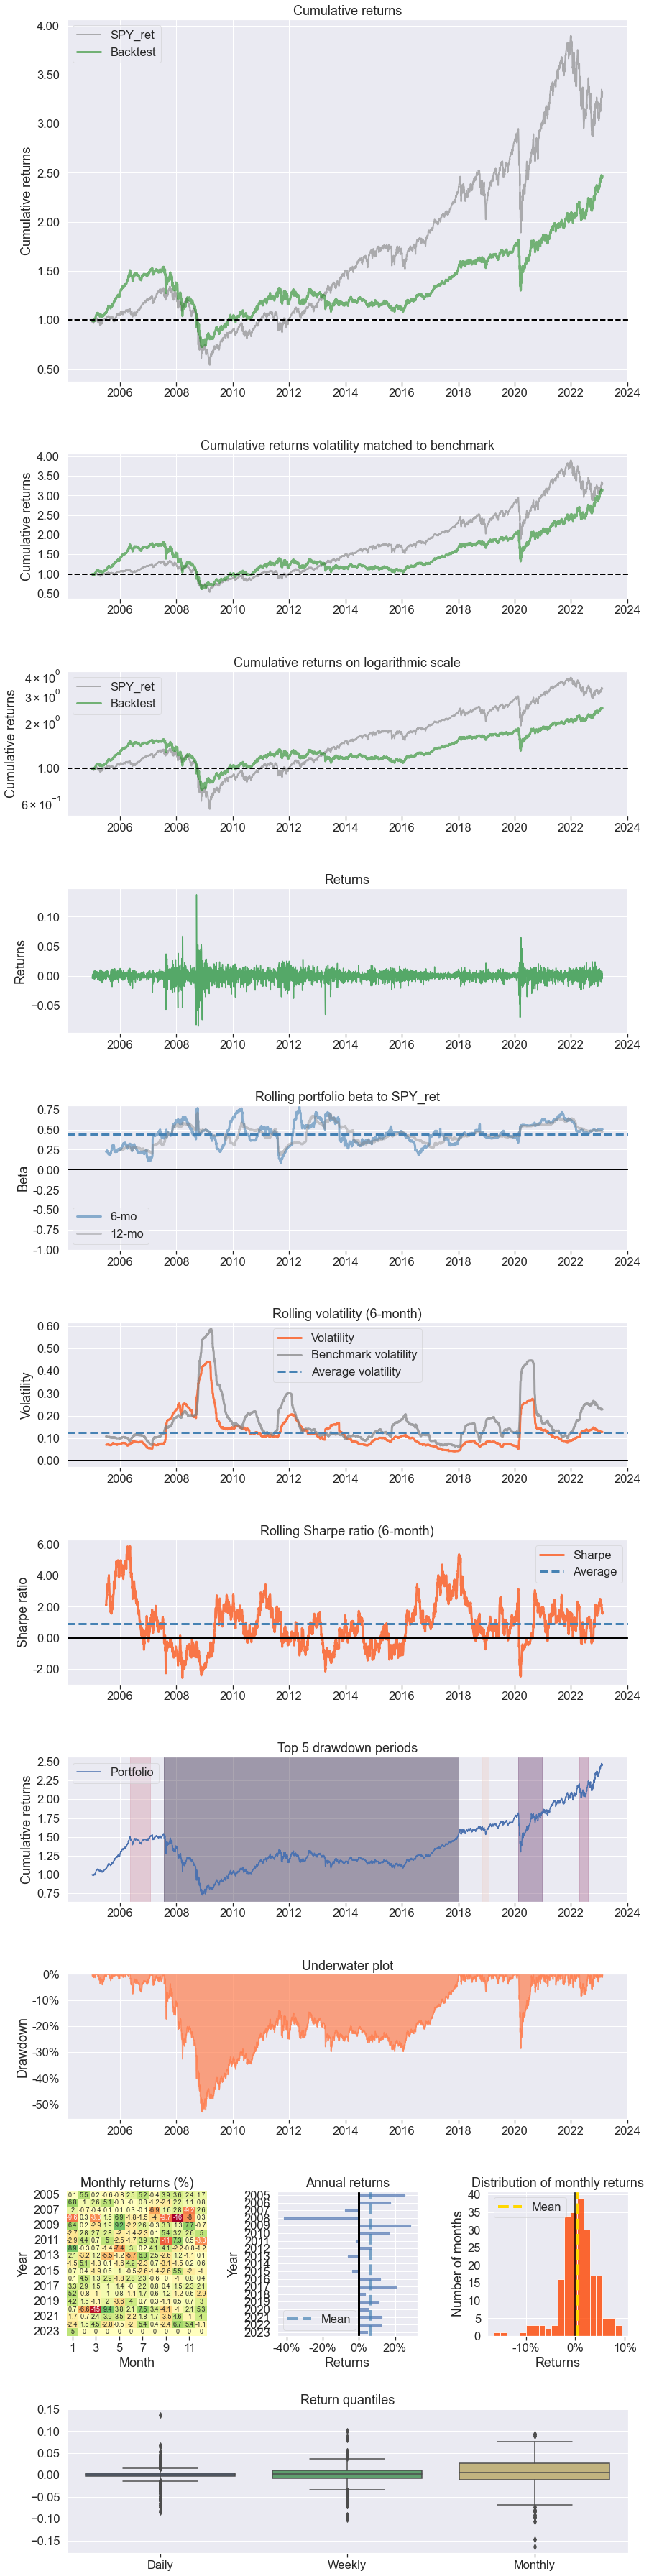

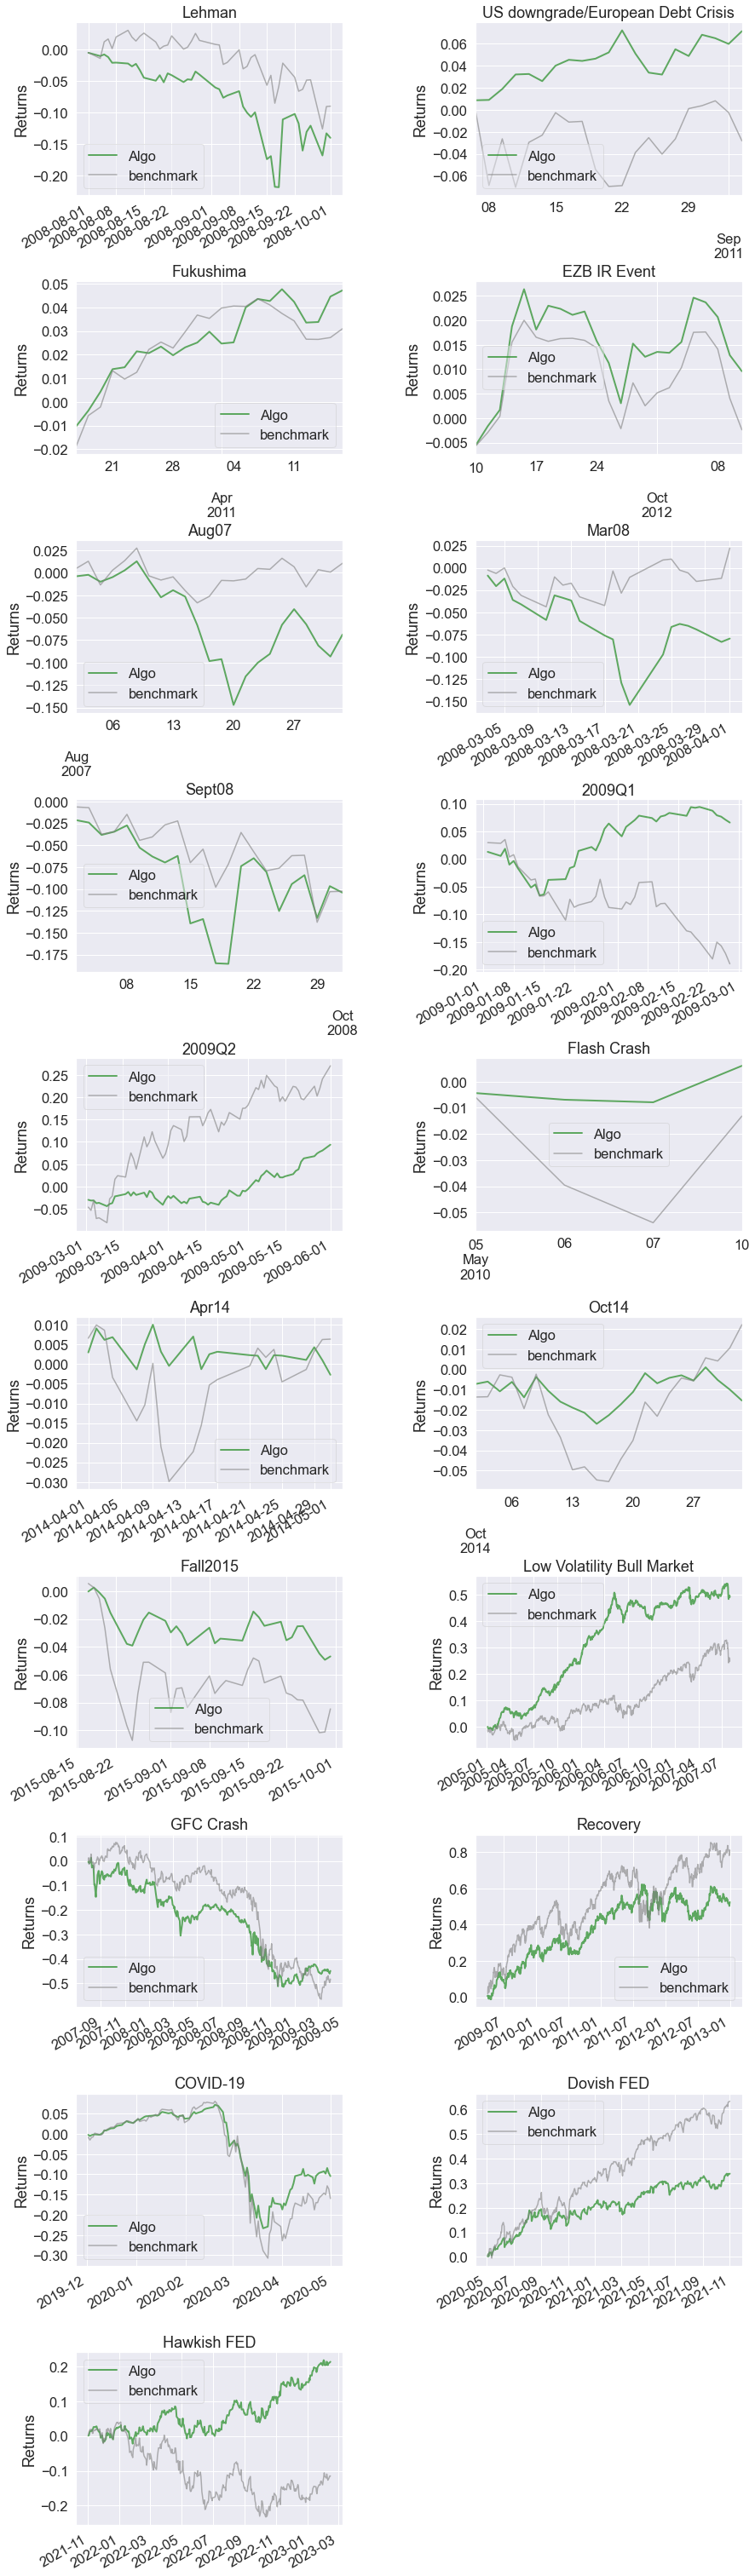

In [9]:
import pyfolio.tears as py

tear_sheet= py.create_full_tear_sheet(stock_data['Portfolio_ret'], benchmark_rets=stock_data['SPY_ret'])

This allows to visually observe the strategy and get some insights from the charts and tables. From a quick overview we would see:

- Our strategy didn't do particularly well from the years 2008 - 2018. 
    - What could have caused this?
    - Is the distribution ok for this policy?
- However, performs better on a Hawkish Federal Reserve period.
    - What makes it work better?
    - Is temporary or sustained?
- It reduces volatility compared to benchmark.
    - What if the volatility is higher and returns lower?
    - Is that strategy aiming the right client?
- Etc, etc.

Then you can go deeper on more quantitative analysis, risks, etc. Potentially, a longer period rebalance, such monthly, quarterly or even yearly would help us to capture returns. As well modifications on the redistribution or assets would bring different results.

### 3. Convert our investment strategy into a ETF.
<hr>

Once we've decided to continue with the strategy, we will convert it into a ETF example. The main key of an ETF is to provide the investor exposure to a basket of assets what you can easily sell or buy on the market, potentially lowering his risk and helping on diversification. In order to do this, it will be few steps to follow once the strategy and the portfolio has been created.

- Define a initial number of shares what the investor would be able to buy-sell.
- Since we don't have market data for our ETF share, we will need to simulate one.
- We will need to implement a system which controls the ratio between the market ETF price and the portfolio. We will do this by controling the number of oustanding shares.

The code sets up a new column in the stock_data DataFrame called sim_ETF_price and initializes its first value.

The initial value of the ETF will be calculated based on the initial portfolio value and the number of initial ETF shares.

In [10]:
# Set the initial price. Portfolio value / shares
stock_data['sim_ETF_price'] = pd.Series(data=np.nan, index=stock_data.index)
stock_data['sim_ETF_price'][0] = stock_data['Portfolio'][0] / initial_etf_shares


- Then, it applies a random noise to each value of the ETF price by adding or subtracting a random number between -0.05 and 0.05 times the current value of the ETF price. 
- The ***np.random.uniform*** function generates uniformly distributed random numbers within the given range. This simulates the volatility and unpredictability of the stock market. 
- The resulting ***sim_ETF_price*** values are not the real market prices, but rather a simulation of the ***possible*** market prices which allows us to implement strategies in order to balance the shares oustanding.

In [11]:
# Price Generation
noise_scale = 0.05
stock_data['sim_ETF_price'] = (stock_data['Portfolio'] / initial_etf_shares) * (1 + np.random.uniform(-noise_scale, noise_scale, size=len(stock_data)))

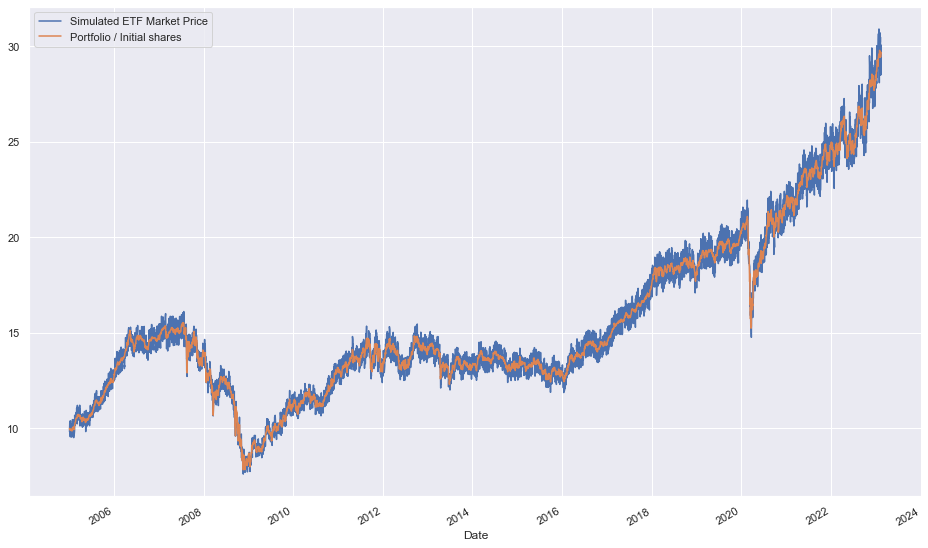

In [12]:
stock_data['sim_ETF_price'].plot(label='Simulated ETF Market Price', figsize=(16, 10))
(stock_data['Portfolio'] / initial_etf_shares).plot(label='Portfolio / Initial shares')
plt.legend(loc="upper left")

This code initializes a new column in the stock_data dataframe named shares_ETF which is filled with NaN values. 

- It then sets the first value of shares_ETF to be the initial_etf_shares $= 100000$ value.
- After that, it calculates the number of shares to hold for the ETF in each subsequent time period. ***Dividing the Portfolio value by the simulated ETF price in each period*** 
- Finally, it rounds down the values in ***shares_ETF*** to the nearest integer using ***np.floor()***. 

The resulting ***shares_ETF*** column will indicate the number of shares to hold in the ETF at each time period in order to maintain the desired asset allocation and a fair value of the price based on the portfolio holding.

In [13]:
stock_data['shares_ETF'] = pd.Series(data=np.nan, index=stock_data.index)
stock_data['shares_ETF'][0] = initial_etf_shares
stock_data['shares_ETF'][1:] = stock_data['Portfolio'][1:] / stock_data['sim_ETF_price'][1:]
stock_data['shares_ETF'] = np.floor(stock_data['shares_ETF'])

Now, similar to what we did to keep the balance of 25% for each asset on the previous step, we will keep track on how the ETF shares should change in order to keep the value in ***stock_data['Trade_ETF_shares'].*** 

For this we will do a report about how the number changes over time. It is worth nothing once we know the ***Portfolio Value*** and the ***Number of ETF shares***, we can get the ***Net Asset Value*** by:

$NAV = PortfolioValue / SharesETF$

This will allow us to track if our system is working effectively by monitoring the ETF market price and the NAV. 

As well we could get useful metrics such ETF Market Cap and compare it with our Portfolio size. Both metrics should be similar.

In [14]:
stock_data['Trade_ETF_shares'] = np.floor(stock_data['shares_ETF']) - np.floor(stock_data['shares_ETF'].shift(1))
stock_data= stock_data.fillna(0)

In [15]:
stock_data['NAV'] = stock_data['Portfolio'] / stock_data['shares_ETF']
stock_data['ETF_MarketCap'] = stock_data['sim_ETF_price'] * stock_data['shares_ETF']

(array([  4.,  18.,  59., 121., 208., 471., 801., 923., 979., 967.]),
 array([-3.04662515e-04, -2.74198264e-04, -2.43734013e-04, -2.13269762e-04,
        -1.82805511e-04, -1.52341260e-04, -1.21877009e-04, -9.14127577e-05,
        -6.09485067e-05, -3.04842557e-05, -2.00047054e-08]),
 <BarContainer object of 10 artists>)

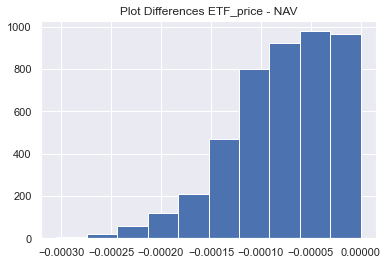

In [16]:
fig1, ax1 = plt.subplots()
ax1.set_title('Plot Differences ETF_price - NAV')
ax1.hist(stock_data['sim_ETF_price'][1:] - stock_data['NAV'][1:])

Once we've checked if our system is workikng you can select small parts of your dataframe to perform different functions. 
For example:
- Get the trading orders to fill (as we will do on the following example)
- Access to returns for metrics
- Observe the holdings
- Etc, etc.

In [17]:
holdings = stocks + ['ETF']
to_trade = stock_data[[f'Trade_{asset}_shares' for asset in holdings]]

In [18]:
to_trade

,Trade_SPY_shares,Trade_GLD_shares,Trade_^TNX_shares,Trade_^IRX_shares,Trade_ETF_shares
Date,,,,,
2005-01-04,0.0,0.0,0.0,0.0,0.0
2005-01-05,10.0,-12.0,-127.0,86.0,-3486.0
2005-01-06,-26.0,51.0,-149.0,313.0,-873.0
2005-01-07,3.0,41.0,-195.0,-516.0,254.0
2005-01-10,-11.0,-10.0,152.0,299.0,7944.0
...,...,...,...,...,...
2023-02-08,13.0,-26.0,435.0,-1110.0,-1210.0
2023-02-09,7.0,14.0,-2591.0,-1731.0,6303.0
2023-02-10,3.0,7.0,-2539.0,-179.0,-5115.0


<AxesSubplot:title={'center':'Porfolio Shares Holding'}>

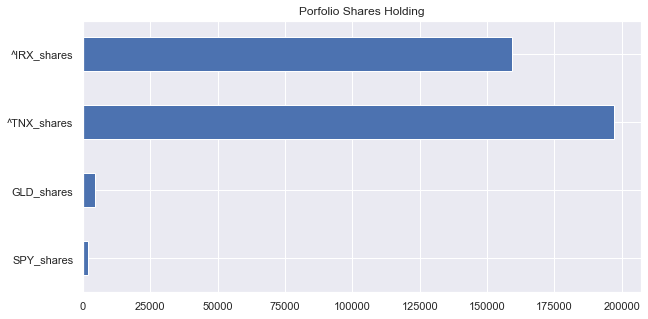

In [19]:
shares = stock_data[[f'{asset}_shares' for asset in stocks]]
shares.iloc[-1].plot.barh(figsize=(10,5), title='Porfolio Shares Holding')


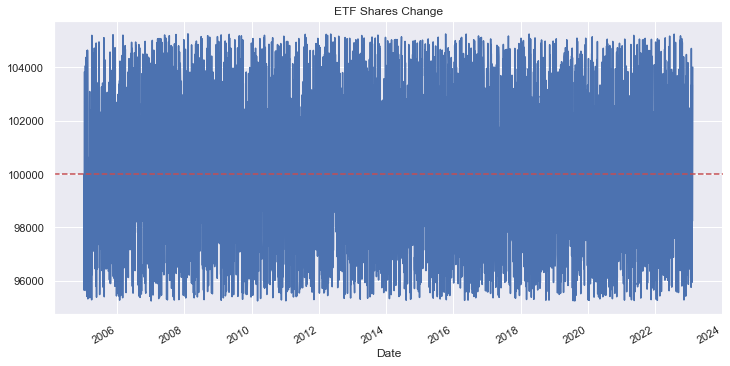

In [20]:
stock_data['shares_ETF'].plot(figsize=(12,6), title='ETF Shares Change')
plt.axhline(initial_etf_shares, color= 'r', linestyle = '--')

Since our strategy was designed to rebalance the value daily, our portfolio keeps the same distribution (25%) per asset at every point.

<AxesSubplot:title={'center':'Porfolio Shares Holding'}>

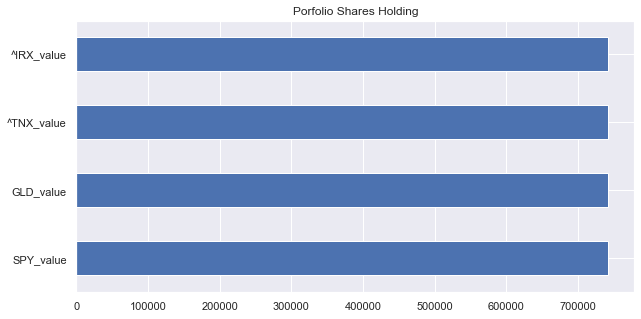

In [21]:
stock_data[[f'{asset}_value' for asset in stocks]].iloc[-1].plot.barh(figsize=(10,5), title='Porfolio Shares Holding')

In [22]:
stock_data.columns

Index(['GLD', 'SPY', '^IRX', '^TNX', 'GLD_ret', 'SPY_ret', '^IRX_ret',
       '^TNX_ret', 'SPY_value', 'SPY_shares', 'Trade_SPY_shares', 'GLD_value',
       'GLD_shares', 'Trade_GLD_shares', '^TNX_value', '^TNX_shares',
       'Trade_^TNX_shares', '^IRX_value', '^IRX_shares', 'Trade_^IRX_shares',
       'Portfolio', 'Portfolio_ret', 'sim_ETF_price', 'shares_ETF',
       'Trade_ETF_shares', 'NAV', 'ETF_MarketCap'],
      dtype='object')

In [23]:
stock_data.head()

,GLD,SPY,^IRX,^TNX,GLD_ret,SPY_ret,^IRX_ret,^TNX_ret,SPY_value,SPY_shares,...,^IRX_value,^IRX_shares,Trade_^IRX_shares,Portfolio,Portfolio_ret,sim_ETF_price,shares_ETF,Trade_ETF_shares,NAV,ETF_MarketCap
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-04,42.740002,83.856934,2.292,4.283,-0.006530,-0.012295,0.039151,0.014819,249977.519043,2981.0,...,249999.906033,109075.0,0.0,999962.404448,0.000000,9.835074,100000.0,0.0,9.999624,983507.401002
2005-01-05,42.669998,83.278305,2.282,4.277,-0.001639,-0.006924,-0.004373,-0.001402,249085.410416,2991.0,...,249105.409079,109161.0,86.0,996360.906919,-0.003608,10.323483,96514.0,-3486.0,10.323486,996360.639344
2005-01-06,42.150002,83.701714,2.267,4.272,-0.012261,0.005071,-0.006595,-0.001170,248175.580711,2965.0,...,248177.553615,109474.0,313.0,992709.901782,-0.003671,10.379505,95641.0,-873.0,10.379543,992706.217310
2005-01-07,41.840000,83.581741,2.277,4.285,-0.007382,-0.001434,0.004401,0.003038,248070.608276,2968.0,...,248097.360597,108958.0,-516.0,992334.535943,-0.000378,10.348132,95895.0,254.0,10.348136,992334.107334
2005-01-10,41.950001,83.976959,2.273,4.278,0.002626,0.004717,-0.001758,-0.001635,248319.868439,2957.0,...,248341.161208,109257.0,299.0,993305.255077,0.000978,9.565809,103839.0,7944.0,9.565821,993304.080737
